In [1]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


Now we will load the English and Hindi pre-trained "FastText" embeddings

In [2]:
import gensim.downloader as api
#Load FastText english
model_eng = api.load("fasttext-wiki-news-subwords-300")
print("English embeddings loaded")


[==================================================] 100.0% 958.5/958.4MB downloaded
English embeddings loaded


In [ ]:
import gensim
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz
!gunzip cc.hi.300.vec.gz

#Load FastText Hindi
model_hindi = gensim.models.KeyedVectors.load_word2vec_format("cc.hi.300.vec", binary=False)
print("Hindi embeddings loaded")

--2025-03-14 03:53:02--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.167.112.129, 3.167.112.51, 3.167.112.53, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.167.112.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1118942272 (1.0G) [binary/octet-stream]
Saving to: ‘cc.hi.300.vec.gz’

cc.hi.300.vec.gz    100%[===================>]   1.04G   135MB/s    in 13s     

2025-03-14 03:53:16 (79.7 MB/s) - ‘cc.hi.300.vec.gz’ saved [1118942272/1118942272]



IIT Bombay English-Hindi Corpus

In [ ]:
!wget https://www.cfilt.iitb.ac.in/iitb_parallel/iitb_corpus_download/small_parallel_en_hi.zip
!unzip small_parallel_en_hi.zip -d iitb_corpus

--2025-03-13 13:21:05--  https://www.cfilt.iitb.ac.in/iitb_parallel/iitb_corpus_download/small_parallel_en_hi.zip
Resolving www.cfilt.iitb.ac.in (www.cfilt.iitb.ac.in)... 103.21.127.134
Connecting to www.cfilt.iitb.ac.in (www.cfilt.iitb.ac.in)|103.21.127.134|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-03-13 13:21:06 ERROR 404: Not Found.

unzip:  cannot find or open small_parallel_en_hi.zip, small_parallel_en_hi.zip.zip or small_parallel_en_hi.zip.ZIP.


Self Created Dictionary

In [20]:
bilingual_dict = {
    "dog": "कुत्ता", "cat": "बिल्ली", "apple": "सेब", "car": "गाड़ी",
    "water": "पानी", "tree": "पेड़", "king": "राजा", "queen": "रानी",
    "book": "किताब", "teacher": "अध्यापक", "computer": "कंप्यूटर", "doctor": "डॉक्टर"
}

In [21]:
english_words = list(bilingual_dict.keys())
hindi_words = list(bilingual_dict.values())

In [22]:
import numpy as np

def get_vector(word, model):

    if word in model:
        return model[word]
    return None  # If word is not found

# Extract embeddings
eng_vectors = []
hin_vectors = []

for en, hi in zip(english_words, hindi_words):
    en_vec = get_vector(en, model_eng)
    hi_vec = get_vector(hi, model_hindi)

    if en_vec is not None and hi_vec is not None:
        eng_vectors.append(en_vec)
        hin_vectors.append(hi_vec)

# Convert to NumPy arrays
eng_vectors = np.array(eng_vectors)
hin_vectors = np.array(hin_vectors)

print(f"Extracted {len(eng_vectors)} word pairs for alignment.")


Extracted 12 word pairs for alignment.


In [23]:
from scipy.linalg import orthogonal_procrustes

# Learn transformation matrix W
W, _ = orthogonal_procrustes(hin_vectors, eng_vectors)

# Transform Hindi embeddings
hin_aligned = hin_vectors @ W

print(f"Hindi embeddings aligned to English space! Shape: {hin_aligned.shape}")

Hindi embeddings aligned to English space! Shape: (12, 300)


In [24]:
from scipy.spatial.distance import cosine

def compare_alignment():
    """Compare similarity before and after alignment"""
    print("\n🔍 Cosine Similarity Before vs. After Alignment:")

    for i, word in enumerate(english_words):
        before = 1 - cosine(eng_vectors[i], hin_vectors[i])  # Before alignment
        after = 1 - cosine(eng_vectors[i], hin_aligned[i])   # After alignment
        print(f"  ✅ {word} ({bilingual_dict[word]}): Before = {before:.4f}, After = {after:.4f}")

# Run the comparison
compare_alignment()


🔍 Cosine Similarity Before vs. After Alignment:
  ✅ dog (कुत्ता): Before = 0.0514, After = 0.9520
  ✅ cat (बिल्ली): Before = -0.0640, After = 0.9708
  ✅ apple (सेब): Before = 0.0122, After = 0.9840
  ✅ car (गाड़ी): Before = 0.1486, After = 0.9728
  ✅ water (पानी): Before = 0.0486, After = 0.9873
  ✅ tree (पेड़): Before = -0.0204, After = 0.9757
  ✅ king (राजा): Before = -0.0307, After = 0.9677
  ✅ queen (रानी): Before = 0.0376, After = 0.9714
  ✅ book (किताब): Before = 0.0545, After = 0.9723
  ✅ teacher (अध्यापक): Before = -0.0470, After = 0.9644
  ✅ computer (कंप्यूटर): Before = 0.0952, After = 0.9575
  ✅ doctor (डॉक्टर): Before = -0.0511, After = 0.9754


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/li

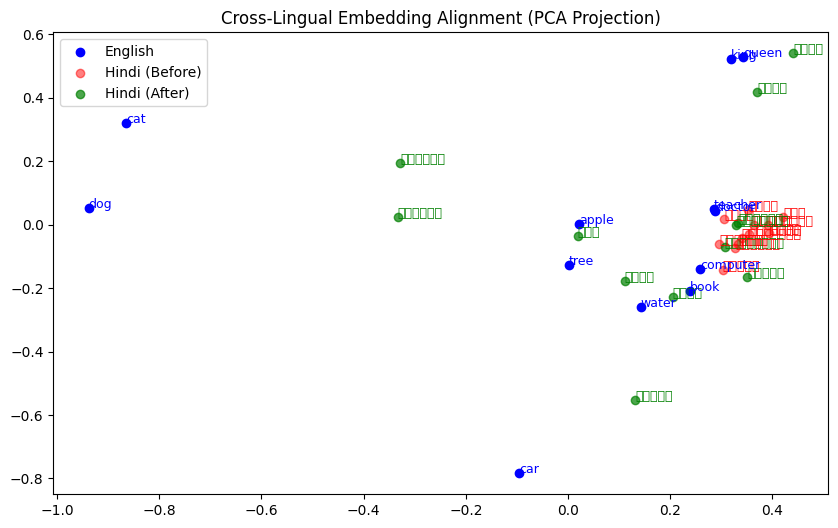

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D
pca = PCA(n_components=2)
eng_2d = pca.fit_transform(eng_vectors)
hin_before_2d = pca.transform(hin_vectors)
hin_after_2d = pca.transform(hin_aligned)

plt.figure(figsize=(10, 6))

# Plot English embeddings
plt.scatter(eng_2d[:, 0], eng_2d[:, 1], color="blue", label="English")
# Plot Hindi embeddings before alignment
plt.scatter(hin_before_2d[:, 0], hin_before_2d[:, 1], color="red", alpha=0.5, label="Hindi (Before)")
# Plot Hindi embeddings after alignment
plt.scatter(hin_after_2d[:, 0], hin_after_2d[:, 1], color="green", alpha=0.7, label="Hindi (After)")

# Annotate words
for i, word in enumerate(english_words):
    plt.annotate(word, (eng_2d[i, 0], eng_2d[i, 1]), fontsize=9, color="blue")
    plt.annotate(bilingual_dict[word], (hin_before_2d[i, 0], hin_before_2d[i, 1]), fontsize=9, color="red")
    plt.annotate(bilingual_dict[word], (hin_after_2d[i, 0], hin_after_2d[i, 1]), fontsize=9, color="green")

plt.title("Cross-Lingual Embedding Alignment (PCA Projection)")
plt.legend()
plt.show()

IITB Corpus

In [26]:
import pandas as pd

with open("test.en", "r", encoding="utf-8") as f:
    english_test_sentences = f.readlines()

with open("test.hi", "r", encoding="utf-8") as f:
    hindi_test_sentences = f.readlines()

with open("dev.en", "r", encoding="utf-8") as f:
    english_dev_sentences = f.readlines()

with open("dev.hi", "r", encoding="utf-8") as f:
    hindi_dev_sentences = f.readlines()

In [27]:
print(f"Sample Test Sentence (English): {english_test_sentences[0]}")
print(f"Sample Test Sentence (Hindi): {hindi_test_sentences[0]}")#Just to check

Sample Test Sentence (English): A black box in your car?

Sample Test Sentence (Hindi): आपकी कार में ब्लैक बॉक्स?



In [28]:
df = pd.DataFrame({
    "English": english_test_sentences + english_dev_sentences,
    "Hindi": hindi_test_sentences + hindi_dev_sentences
})
df.head()

,English,Hindi
0,A black box in your car?\n,आपकी कार में ब्लैक बॉक्स?\n
1,As America's road planners struggle to find th...,"जबकि अमेरिका के सड़क योजनाकार, ध्वस्त होते हुए..."
2,"The devices, which track every mile a motorist...","यह डिवाइस, जो मोटर-चालक द्वारा वाहन चलाए गए प्..."
3,The usually dull arena of highway planning has...,आम तौर पर हाईवे नियोजन जैसा उबाऊ काम भी अचानक ...
4,Libertarians have joined environmental groups ...,"आपने द्वारा ड्राइव किए गए मील, तथा संभवतः ड्रा..."


In [29]:
import random

sample_df=df.sample(500, random_state=42)

#Let's tokenize both languages
english_words=set()
hindi_words=set()
bilingual_dict={}

for _,row in sample_df.iterrows():
  eng_tokens=row['English'].strip().lower().split()
  hin_tokens=row['Hindi'].strip().lower().split()

  for eng, hin in zip(eng_tokens[:10], hin_tokens[:10]):
    english_words.add(eng)
    hindi_words.add(hin)
    bilingual_dict[eng] = hin

print(f"Sample bilingual dictionary:", list(bilingual_dict.items())[:10])

Sample bilingual dictionary: [('during', 'उपलब्ध'), ('this', 'इस'), ('time', 'समय'), ('more', 'विश्वदाय'), ('than', 'धरोहर'), ('a', 'एक'), ('dozen', 'बायोटेक्नोलॉजी,'), ('employees', 'की'), ('of', 'और'), ('these', 'में')]


In [36]:
def get_vector(word, model):

    if word in model:
        return model[word]
    return None  # If word is not found

# Extract embeddings
eng_vectors = []
hin_vectors = []


valid_pairs = []

for en, hi in bilingual_dict.items():
    en_vec = get_vector(en, model_eng)
    hi_vec = get_vector(hi, model_hindi)

    if en_vec is not None and hi_vec is not None:
        eng_vectors.append(en_vec)
        hin_vectors.append(hi_vec)
        valid_pairs.append((en, hi))

# Convert to NumPy arrays
eng_vectors = np.array(eng_vectors)
hin_vectors = np.array(hin_vectors)

print(f"Extracted {len(eng_vectors)} word pairs for alignment.")

Extracted 1550 word pairs for alignment.


In [37]:
W, _ = orthogonal_procrustes(hin_vectors, eng_vectors)

# Transform Hindi embeddings
hin_aligned = hin_vectors @ W

print(f"Hindi embeddings aligned to English space! Shape: {hin_aligned.shape}")

Hindi embeddings aligned to English space! Shape: (1550, 300)


In [39]:
def compare_alignment1():
    print("\n Cosine Similarity Before vs. After Alignment:")

    for i, (eng,hin) in enumerate(valid_pairs[:200]):
        before = 1 - cosine(eng_vectors[i], hin_vectors[i])  # Before alignment
        after = 1 - cosine(eng_vectors[i], hin_aligned[i])   # After alignment
        print(f"{eng} ({hin}): Before = {before:.4f}, After = {after:.4f}")

# Run the comparison
compare_alignment1()


 Cosine Similarity Before vs. After Alignment:
during (उपलब्ध): Before = 0.1296, After = 0.2576
this (इस): Before = -0.0047, After = 0.6286
time (समय): Before = 0.1024, After = 0.5609
more (विश्वदाय): Before = 0.0312, After = 0.2957
than (धरोहर): Before = -0.0483, After = 0.5156
a (एक): Before = 0.0334, After = 0.2357
employees (की): Before = 0.0247, After = 0.4137
of (और): Before = 0.0124, After = 0.5385
these (में): Before = 0.0327, After = 0.6105
they (कृत्य): Before = 0.0161, After = 0.3328
argue (तर्क): Before = 0.0727, After = 0.5932
that (में): Before = 0.0458, After = 0.4814
luggage (हैं): Before = -0.1090, After = 0.3328
costs (के): Before = 0.0383, After = 0.5195
money (व्यक्ति): Before = 0.0388, After = 0.3373
and (की): Before = 0.0047, After = 0.5122
passengers (एयरलाइन): Before = 0.0209, After = 0.4267
the (उनके): Before = 0.1130, After = 0.5444
family (ने): Before = 0.0134, After = 0.3908
members (बाजार): Before = 0.0717, After = 0.2189
are (भिन्न): Before = 0.0972, Afte

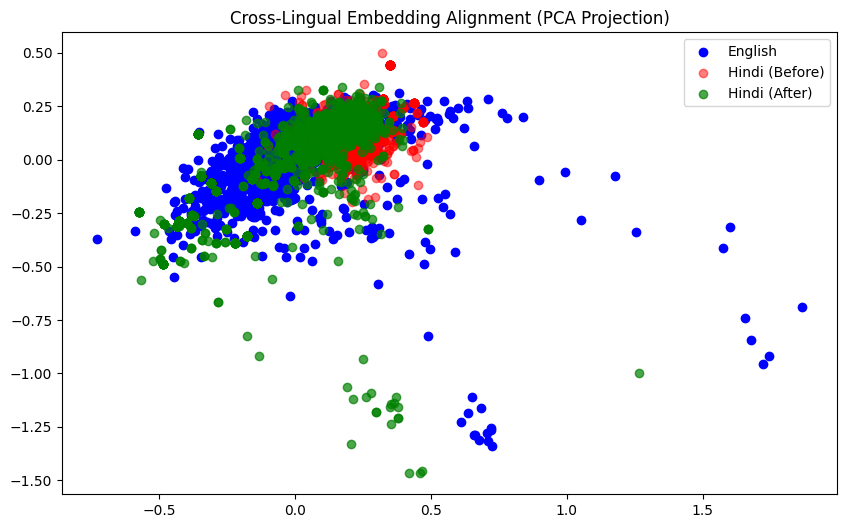

In [40]:
pca = PCA(n_components=2)
eng_2d = pca.fit_transform(eng_vectors)
hin_before_2d = pca.transform(hin_vectors)
hin_after_2d = pca.transform(hin_aligned)

plt.figure(figsize=(10, 6))

# Plot embeddings
plt.scatter(eng_2d[:, 0], eng_2d[:, 1], color="blue", label="English")
plt.scatter(hin_before_2d[:, 0], hin_before_2d[:, 1], color="red", alpha=0.5, label="Hindi (Before)")
plt.scatter(hin_after_2d[:, 0], hin_after_2d[:, 1], color="green", alpha=0.7, label="Hindi (After)")

plt.title("Cross-Lingual Embedding Alignment (PCA Projection)")
plt.legend()
plt.show()